In [1]:
!pip install minisom


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12043 sha256=ff0db8dd87eb209ae111184494f3a3a9c1d43a4df4fd104edc075aeaee2993fc
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\df\bc\51\5a64336510519dc8062d6e17d458721906b85b09abe192481e
Successfully built minisom


  DEPRECATION: Building 'minisom' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'minisom'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from minisom import MiniSom
from sklearn.preprocessing import StandardScaler


In [3]:
# Load datasets
train_df = pd.read_csv("train.csv")
new_df   = pd.read_csv("new_customers.csv")

print("Train shape:", train_df.shape)
print("New data shape:", new_df.shape)

train_df.head()


Train shape: (8068, 11)
New data shape: (2627, 11)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [6]:
train_num_cols = train_df.select_dtypes(include=[np.number]).columns
new_num_cols   = new_df.select_dtypes(include=[np.number]).columns

common_cols = train_num_cols.intersection(new_num_cols)

print("Common numeric columns:")
print(common_cols)



Common numeric columns:
Index(['ID', 'Age', 'Work_Experience', 'Family_Size'], dtype='object')


In [7]:
X_train = train_df[common_cols]
X_new   = new_df[common_cols]

print("X_train shape:", X_train.shape)
print("X_new shape:", X_new.shape)


X_train shape: (8068, 4)
X_new shape: (2627, 4)


In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_new_scaled   = scaler.transform(X_new)


In [9]:
n_samples = X_train_scaled.shape[0]
grid_size = int(np.sqrt(5 * np.sqrt(n_samples)))

som_x, som_y = grid_size, grid_size
input_len = X_train_scaled.shape[1]

print(f"SOM Grid Size: {som_x} x {som_y}")


SOM Grid Size: 21 x 21


In [10]:
som = MiniSom(
    x=som_x,
    y=som_y,
    input_len=input_len,
    sigma=1.2,
    learning_rate=0.5,
    neighborhood_function='gaussian',
    random_seed=42
)

som.random_weights_init(X_train_scaled)


In [11]:
som.train_random(
    data=X_train_scaled,
    num_iteration=3000,
    verbose=True
)


 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: nan


In [13]:
# Check variance of each feature (critical for SOM)
X_train.var().sort_values()



Family_Size        2.345227e+00
Work_Experience    1.160603e+01
Age                2.792808e+02
ID                 6.736004e+06
dtype: float64

In [14]:
# Drop ID column (never use identifiers in SOM)
X_train = X_train.drop(columns=["ID"])
X_new   = X_new.drop(columns=["ID"])

X_train.head()


,Age,Work_Experience,Family_Size
0,22,1.0,4.0
1,38,NaN,3.0
2,67,1.0,1.0
3,67,0.0,2.0
4,40,NaN,6.0


In [15]:
# Fill missing values using median (robust choice)
X_train = X_train.fillna(X_train.median())
X_new   = X_new.fillna(X_train.median())  # use TRAIN median only

# Verify no NaNs remain
X_train.isna().sum()


Age                0
Work_Experience    0
Family_Size        0
dtype: int64

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_new_scaled   = scaler.transform(X_new)

# Quick sanity check
X_train_scaled[:5]


array([[-1.28462344, -0.45113599,  0.76269849],
       [-0.32715082, -0.45113599,  0.09580227],
       [ 1.40826831, -0.45113599, -1.23799017],
       [ 1.40826831, -0.7574104 , -0.57109395],
       [-0.20746674, -0.45113599,  2.09649094]])

In [17]:
# SAFE grid size for low-dimensional data
som_x, som_y = 8, 8   # do NOT increase yet
input_len = X_train_scaled.shape[1]

print("SOM grid:", som_x, "x", som_y)
print("Input dimension:", input_len)


SOM grid: 8 x 8
Input dimension: 3


In [18]:
from minisom import MiniSom

som = MiniSom(
    x=som_x,
    y=som_y,
    input_len=input_len,
    sigma=2.0,            # large neighborhood to start
    learning_rate=0.3,    # stable learning
    neighborhood_function='gaussian',
    random_seed=42
)

# IMPORTANT: initialize using data distribution
som.random_weights_init(X_train_scaled)

print("SOM initialized successfully")


SOM initialized successfully


In [19]:
# Train SOM (needs sufficient iterations)
som.train_random(
    data=X_train_scaled,
    num_iteration=8000,   # do NOT reduce
    verbose=True
)


 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.40080845400269494


U-Matrix min: 0.15528704252769593
U-Matrix max: 1.0


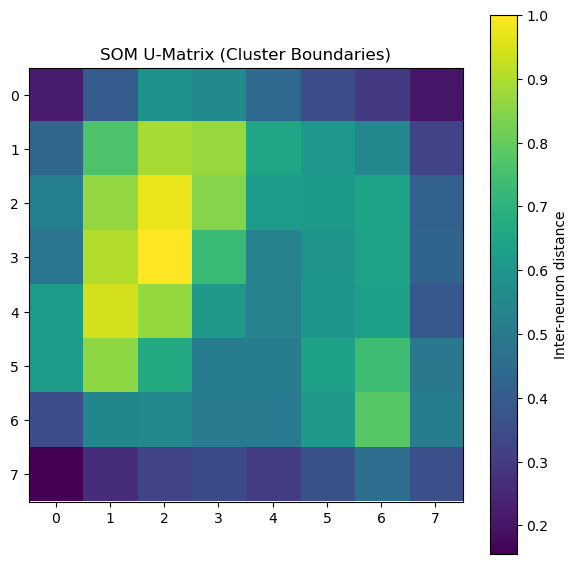

In [20]:
# Compute U-Matrix
u_matrix = som.distance_map()

print("U-Matrix min:", u_matrix.min())
print("U-Matrix max:", u_matrix.max())

plt.figure(figsize=(7,7))
plt.imshow(u_matrix.T, cmap='viridis')
plt.colorbar(label="Inter-neuron distance")
plt.title("SOM U-Matrix (Cluster Boundaries)")
plt.show()


In [21]:
# Find BMU for each training sample
train_bmus = np.array([som.winner(x) for x in X_train_scaled])

# Convert (x, y) → single cluster ID
train_clusters = np.ravel_multi_index(
    train_bmus.T,
    dims=(som_x, som_y)
)

train_df["SOM_Cluster"] = train_clusters
train_df[["Age", "Work_Experience", "Family_Size", "SOM_Cluster"]].head()


,Age,Work_Experience,Family_Size,SOM_Cluster
0,22,1.0,4.0,39
1,38,NaN,3.0,28
2,67,1.0,1.0,40
3,67,0.0,2.0,41
4,40,NaN,6.0,62


In [22]:
# Find BMU for each new sample
new_bmus = np.array([som.winner(x) for x in X_new_scaled])

# Convert (x, y) → single cluster ID
new_clusters = np.ravel_multi_index(
    new_bmus.T,
    dims=(som_x, som_y)
)

new_df["SOM_Cluster"] = new_clusters

new_df[["Age", "Work_Experience", "Family_Size", "SOM_Cluster"]].head()


,Age,Work_Experience,Family_Size,SOM_Cluster
0,36,0.0,1.0,7
1,37,8.0,4.0,11
2,69,0.0,1.0,40
3,59,11.0,2.0,16
4,19,NaN,4.0,39


In [23]:
# Profile clusters by mean feature values
cluster_profile = (
    train_df
    .groupby("SOM_Cluster")[["Age", "Work_Experience", "Family_Size"]]
    .mean()
    .round(2)
)

cluster_profile.head(10)


,Age,Work_Experience,Family_Size
SOM_Cluster,,,
0,38.07,12.31,1.42
1,29.29,9.05,1.73
2,28.51,10.00,3.16
3,29.53,8.78,4.97
4,24.51,6.45,3.88
5,28.59,4.64,1.82
6,30.41,1.09,1.00
7,40.78,0.50,1.00
8,43.08,8.66,1.08


In [24]:
# Quantization error for each training sample
train_qe = np.array([
    np.linalg.norm(x - som.get_weights()[som.winner(x)])
    for x in X_train_scaled
])

train_df["SOM_Quantization_Error"] = train_qe

# Flag top 5% anomalies
threshold = np.percentile(train_qe, 95)
train_df["SOM_Anomaly"] = train_qe > threshold

train_df[["Age", "Work_Experience", "Family_Size",
          "SOM_Cluster", "SOM_Quantization_Error", "SOM_Anomaly"]].head()


,Age,Work_Experience,Family_Size,SOM_Cluster,SOM_Quantization_Error,SOM_Anomaly
0,22,1.0,4.0,39,0.157447,False
1,38,NaN,3.0,28,0.123033,False
2,67,1.0,1.0,40,0.258403,False
3,67,0.0,2.0,41,0.265292,False
4,40,NaN,6.0,62,0.123617,False


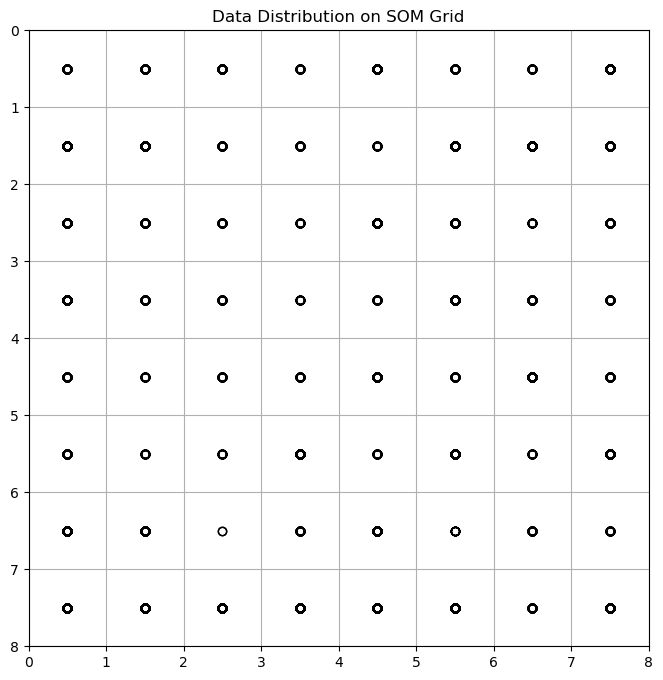

In [25]:
plt.figure(figsize=(8, 8))

for x in X_train_scaled:
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'o',
             markerfacecolor='None',
             markeredgecolor='black',
             markersize=6)

plt.title("Data Distribution on SOM Grid")
plt.xlim([0, som_x])
plt.ylim([0, som_y])
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()



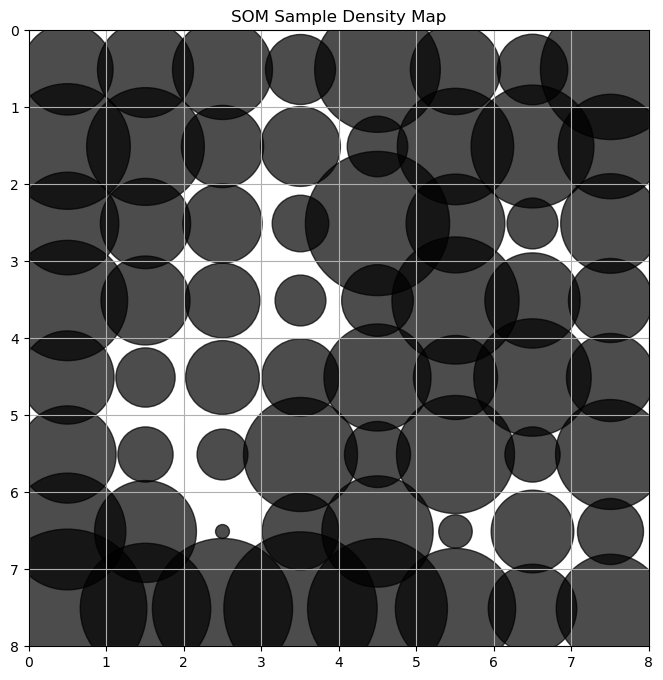

In [26]:
# Count how many samples map to each neuron
from collections import Counter

bmu_counts = Counter([som.winner(x) for x in X_train_scaled])

plt.figure(figsize=(8, 8))

for (x, y), count in bmu_counts.items():
    plt.scatter(
        x + 0.5, y + 0.5,
        s=20 + count * 40,   # size ∝ density
        c='black',
        alpha=0.7
    )

plt.title("SOM Sample Density Map")
plt.xlim([0, som_x])
plt.ylim([0, som_y])
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


In [27]:
# Extract SOM neuron weights
weights = som.get_weights()   # shape: (som_x, som_y, n_features)

# Reshape to (num_neurons, n_features)
neuron_weights = weights.reshape(som_x * som_y, input_len)

neuron_weights.shape


(64, 3)

In [28]:
from sklearn.cluster import KMeans

# Number of macro-segments (interpretable, not too many)
n_macro_clusters = 4

kmeans_neurons = KMeans(
    n_clusters=n_macro_clusters,
    random_state=42,
    n_init=20
)

neuron_macro_labels = kmeans_neurons.fit_predict(neuron_weights)

# Check distribution
np.bincount(neuron_macro_labels)


C:\Users\ADMIN\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ADMIN\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\ADMIN\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ADMIN\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

array([22, 14, 14, 14])

In [29]:
# Map each training sample to its macro-segment
train_macro_segments = []

for x in X_train_scaled:
    bmu = som.winner(x)
    neuron_index = np.ravel_multi_index(bmu, dims=(som_x, som_y))
    train_macro_segments.append(neuron_macro_labels[neuron_index])

train_df["Macro_Segment"] = train_macro_segments

train_df[["Age", "Work_Experience", "Family_Size", "Macro_Segment"]].head()


,Age,Work_Experience,Family_Size,Macro_Segment
0,22,1.0,4.0,3
1,38,NaN,3.0,0
2,67,1.0,1.0,1
3,67,0.0,2.0,1
4,40,NaN,6.0,3


In [30]:
# Macro-segment interpretation
macro_profile = (
    train_df
    .groupby("Macro_Segment")[["Age", "Work_Experience", "Family_Size"]]
    .mean()
    .round(2)
)

macro_profile


,Age,Work_Experience,Family_Size
Macro_Segment,,,
0,36.78,1.09,2.24
1,67.47,0.82,1.94
2,38.24,8.26,2.70
3,35.64,0.88,4.86


In [31]:
# Define semantic labels for macro-segments
segment_labels = {
    0: "Early_Career_Adults",
    1: "Senior_Retired",
    2: "Established_Professionals",
    3: "Family_Oriented"
}

# Apply labels
train_df["Segment_Label"] = train_df["Macro_Segment"].map(segment_labels)

train_df[["Age", "Work_Experience", "Family_Size",
          "Macro_Segment", "Segment_Label"]].head()


,Age,Work_Experience,Family_Size,Macro_Segment,Segment_Label
0,22,1.0,4.0,3,Family_Oriented
1,38,NaN,3.0,0,Early_Career_Adults
2,67,1.0,1.0,1,Senior_Retired
3,67,0.0,2.0,1,Senior_Retired
4,40,NaN,6.0,3,Family_Oriented


In [32]:
# Map new data to macro-segments
new_macro_segments = []

for x in X_new_scaled:
    bmu = som.winner(x)
    neuron_index = np.ravel_multi_index(bmu, dims=(som_x, som_y))
    new_macro_segments.append(neuron_macro_labels[neuron_index])

new_df["Macro_Segment"] = new_macro_segments
new_df["Segment_Label"] = new_df["Macro_Segment"].map(segment_labels)

new_df[["Age", "Work_Experience", "Family_Size",
        "Macro_Segment", "Segment_Label"]].head()


,Age,Work_Experience,Family_Size,Macro_Segment,Segment_Label
0,36,0.0,1.0,0,Early_Career_Adults
1,37,8.0,4.0,2,Established_Professionals
2,69,0.0,1.0,1,Senior_Retired
3,59,11.0,2.0,2,Established_Professionals
4,19,NaN,4.0,3,Family_Oriented


In [34]:
def topographic_error(som, X):
    error = 0
    
    weights = som.get_weights()           # shape: (x, y, n_features)
    som_x, som_y, n_features = weights.shape
    weights_reshaped = weights.reshape(-1, n_features)

    for x in X:
        # First BMU
        bmu1 = som.winner(x)
        
        # Distances to all neurons
        dists = np.linalg.norm(weights_reshaped - x, axis=1)
        
        # Second BMU
        bmu2_idx = np.argsort(dists)[1]
        bmu2 = np.unravel_index(bmu2_idx, (som_x, som_y))
        
        # Check adjacency
        if abs(bmu1[0] - bmu2[0]) > 1 or abs(bmu1[1] - bmu2[1]) > 1:
            error += 1

    return error / len(X)


In [35]:
topographic_error(som, X_train_scaled)


0.05156172533465543

In [36]:
train_df.groupby("Macro_Segment")[["Age","Work_Experience","Family_Size"]].std()


,Age,Work_Experience,Family_Size
Macro_Segment,,,
0,9.184715,1.343883,0.836892
1,10.771338,1.086500,0.839805
2,11.922966,2.040431,1.406330
3,12.761632,1.239087,1.198824


In [37]:
train_df.groupby("Macro_Segment")[["Age","Work_Experience","Family_Size"]].mean()


,Age,Work_Experience,Family_Size
Macro_Segment,,,
0,36.777211,1.092658,2.237110
1,67.467011,0.824289,1.937088
2,38.242042,8.261862,2.695597
3,35.638372,0.884381,4.860465
